# Conditional Deep Convolutional Generative Adversarial Network (cDCGAN)

## Abstract
For this assignment, I decided to build a conditional DCGAN (cDCGAN) to generate images based on their class labels. The conditional GAN was first suggested by Mirza and Osindero (2014), and embeds class labels, $y$, of a given dataset, $x$, into both the discriminator and generator of the GAN to enable the creation of targeted images. The results showed .. for CIFAR10, and ... for my custom dataset. I suspect that _insert reasons for failure here_, and suggest _improvements_ in future iterations.


## Introduction

According to Mirza and Osindero (2014), "Generative adversarial nets can be extended to a conditional model if both the generator and discriminator are conditioned on some extra information $y$. $y$ could be any kind of auxiliary information,
such as class labels or data from other modalities. We can perform the conditioning by feeding $y$ into both the discriminator and generator as additional input layer."

Some motivations for including the class label within the input are (Brownlee, 2019):

- To improve GAN performance by making use of additional information (class labels) that is correlated with the input images.

- To generated targeted images.

## Encoding Class Labels

In a vanilla conditional GAN network with linear layers, $y$ could be embedded into the input via simple concatenation. According to Brownlee (2019), one of the best practices in encoding and incorporating class labels into both the discriminator and generator models entails "using an embedding layer followed by a fully connected layer with a linear activation that scales the embedding to the size of the image before concatenating it in the model as an additional channel or feature map".

In a conditional DCGAN network with convolutional layers, the encoding of class labels becomes a bit trickier since the images are not flattened into a single dimension before being fed into the network. Instead, the DCGAN network normally takes in an input of 3 dimensions, i.e. width x heights x number of channels. The image is then continuously convolved through multiple kernels in the network without ever having to be flattened until a final classification decision has to be made using a linear layer (e.g. sigmoid) at the output. 

## Main References

To build my cDCGAN model, I made heavy reference of the following sources:

- **Pytorch DCGAN Tutorial (Inkawhich, 2017).** The tutorial walked through the concept and implementation of the DCGAN model in Pytorch.


- **Conditional GAN Code in Pytorch (Linder-Noren, 2019).** This Github repo covers the implementation of a regular conditional GAN model. Linder-Noren made use of Pytorch's `nn.Embedding` layer to embed the class labels in the model. He concatenated the embedding layer with the flattened input before feeding it into the GAN network. Since I was using a conditional DCGAN, I could only borrow his idea of using a `nn.Embedding` layer but still needed to figure out an appropriate location in the architecture where I could embed my class labels.


- **Conditional DCGAN Tutorial in Keras (Desai, 2018).** This Medium post walked through the implementation of a conditional DCGAN in Keras. Desai noted that "It wasn’t really intuitive ... how the conditioning input can be applied to the Convolutional layers of the Discriminator", but ultimately justified concatenating the labels right before the fully connected layers (near the end of the network) on the basis that "the Discriminator is learning high level features from the image and using them in conjunction with the conditioning input to make the final decision". This was the method I used to embed my class labels in my cDCGAN model.


- **cGAN and cDCGAN on MNIST and Celeb Faces in Pytorch (Kang, 2017).** This Github repo implements both a conditional GAN and conditional DCGAN in Pytorch to generate MNIST digits and celebrity faces. In contrast to Desai (2018), Kang (2017) embedded the class labels to the input very early on in the discriminator by first feeding the image and class labels seperately into the same convolutional layer, so that both the image and class labels have the same output shape after the first convolution. After that, the image and class labels are concatenated together and fed through the rest of the network. The figure below illustrates Kang's methodology:

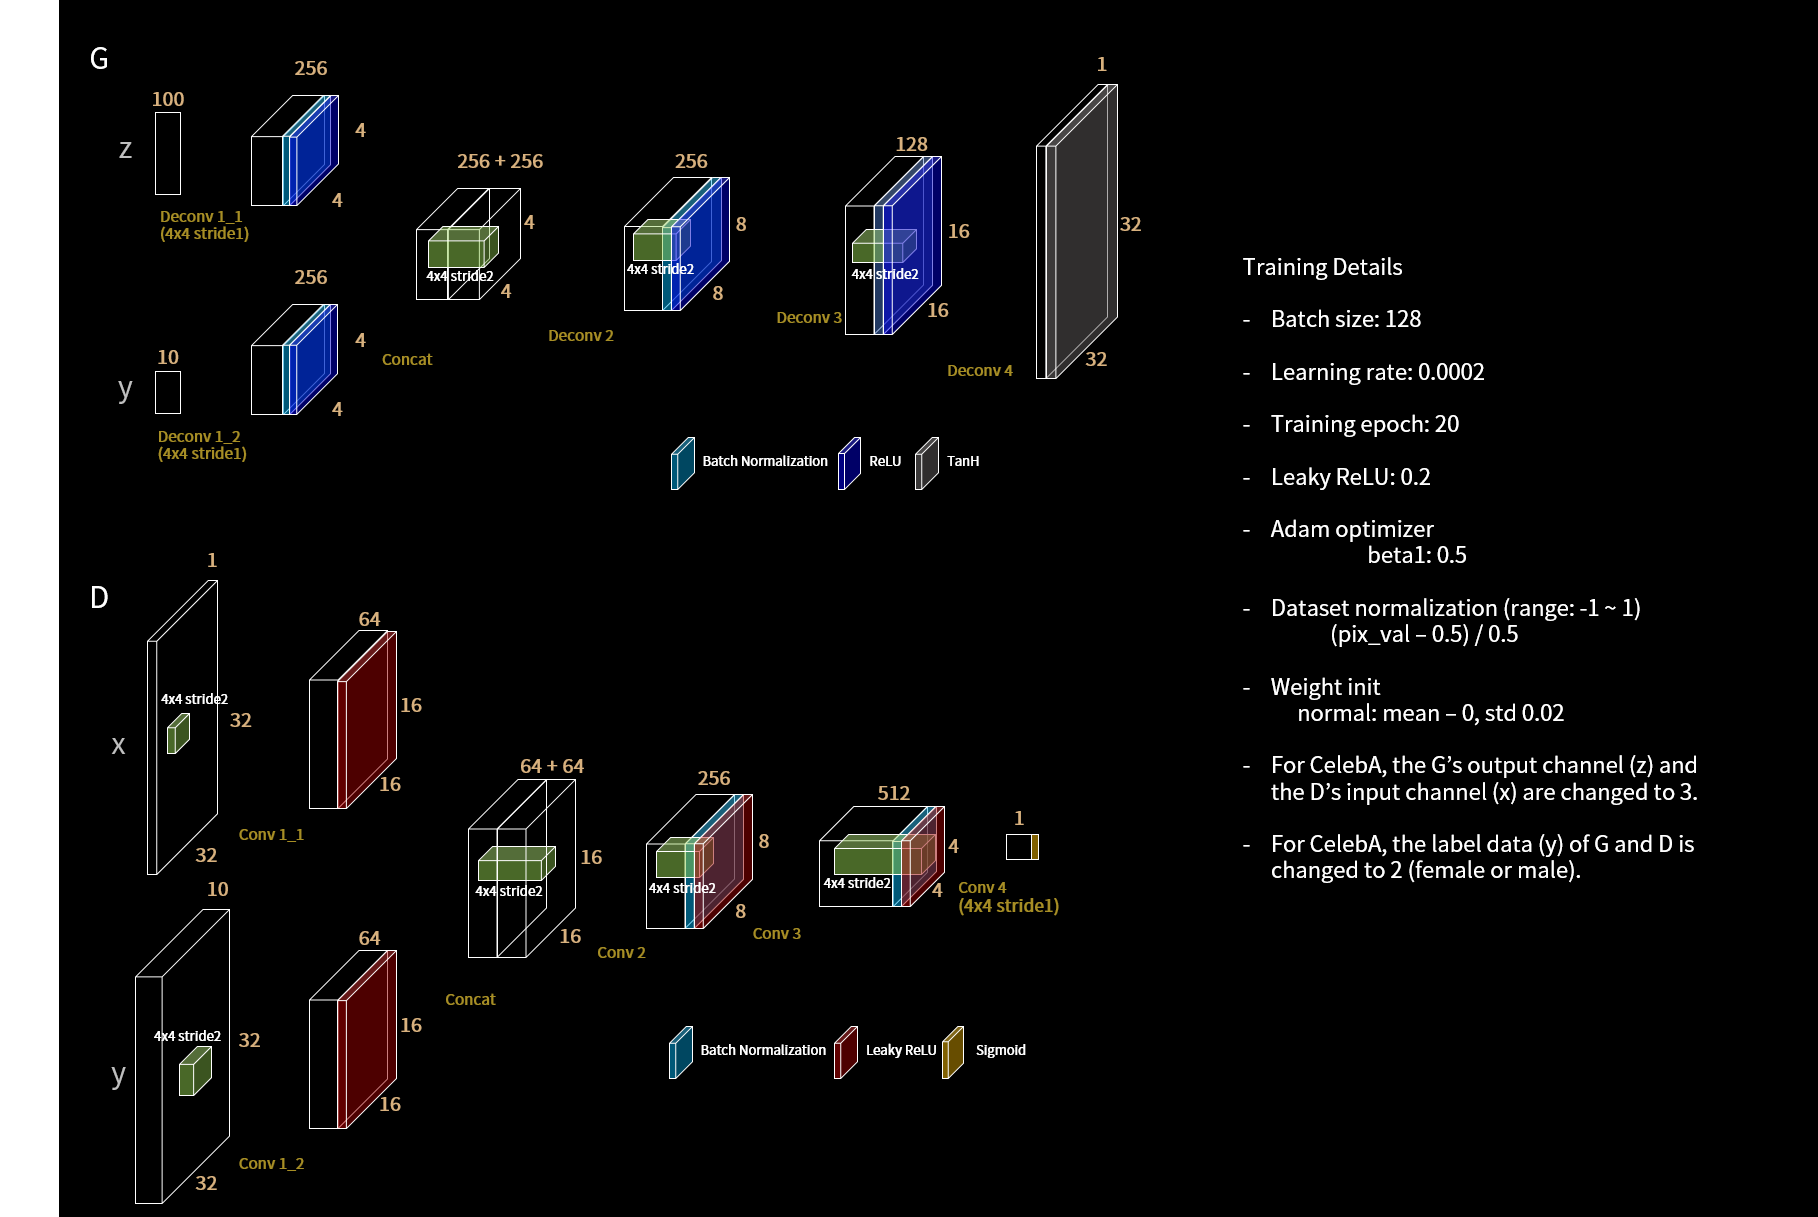

## Architectural Choices

### Conditional Discriminator

My biggest challenge in building the conditional discriminator was deciding on how to embed the class labels into the network. Linder-Noren (2019) simply concatenated the class labels with the input before feeding it into the network, but he could do so because he was using a regular conditional GAN without convolutional layers. Convolutional layers take in multidimensional inputs, and so the concatenation of class labels is not as straightforward as if the input was 1-dimensional.

The two main ways of embedding class labels that I considered were:

- Kang's (2017) method of embedding the class labels to the image after feeding both through a convolutional layer. This means the image was "conditioned" on the class before going through the main convolutional layers.


- Desai's (2018) method of embedding the class labels to the image after the convolutional layers, but before the input is fed into the linear layers section of the network. That is, given a conventional deep CNN model structured as `INPUT -> [CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC` (Karpathy and Johnson, 2017), the class labels will be concatenated after the `CONV` block but before the `FC` layers.

I decided to follow Desai's (2018) method as I liked his reasoning that the class label should be considered a "higher-level" feature that would be embedded near the tail-end of the conditional DCGAN to provide further information to the network.

**Convolutional Layers in Discriminator** - The convolutional layers of my discriminator were based on the Pytorch DCGAN tutorial (Inkawhich, 2017), which was in turn, based on the original DCGAN paper ().

**Embedding the Class Label** - The output from the final convolutional layer is flattened and concatenated with the class label layer to create a "conditioned" layer of dimension: [batch size, number of classes + 1]. For example, with a batch size of 128 and 3 class labels, the convolutional layer output is flattened to [128, 1], the class labels are represented as an embedded layer of [128, 3], and so the concatenated layer is [128, 3+1] = [128, 4].

**Linear Layers in Discriminator**
The concatenated layer was then fed into a `FC -> LeakyRELU` block right before the final sigmoid layer. This was mostly just following Desai's (2018) architecture, with minor tweaking on my end to adjust the number of input and output features. I used 512 output features for the linear layer because that was the number used by both Desai (2018) and Linder-Noren (2017), though frankly I am uncertain whether there is a strong for them doing so.

Since Desai's (2018) code was written in Keras, I followed his choice of concatenation placement, but referenced Linder-Noren's (2017) implementation of Pytorch's `nn.Embedding` layer to embed the class labels.

### Conditional Generator

The conditional generator was relatively simpler to implement. I followed Desai's (2018) method of first concatenating the class labels with the input noise to produce a 1D input, before reshaping the 1D input into a 3D input with dimensions [latent vector size + number of class labels, 1, 1]. This 3D input was then fed into the convolutional layers to generate a fake image.

### Complete Conditional Model

The complete model is similar to the DCGAN model, except that an additional class label input is now fed into both the discriminator and the generator to be embedded and used within the network.

Aside from adding class labels as an additional parameter, an additional step was to generate fake labels for generating fake images and training the discriminator on the fake images:

`generated_labels = torch.randint(self.n_classes(b_size,)).type(torch.LongTensor)`

where `n_classes` is the number of classes, and `b_size` is the batch size. The output is a tensor of size `[b_size, n_classes]`, so that an equal sized batch of fake images is created for each class by the generator, and the discriminator is able to train on these fake images.


## Data

The data used in training was the CIFAR10 dataset, and a custom dataset consisting of cartoon, cyberpunk, and noir classes of digital artwork scraped from artstation.com. The classes have 9924, 9859, and 3567 entries respectively. 

On hindsight, the imbalance in the classes may have been contributing to mode collapse in my model, but I did not want to balance the classes since that would result in cutting roughly 60% of the cartoon and cyberpunk classes. Since I was building a GAN, I figured that the class imbalance was acceptable. However, the inclusion of class labels in the input may have caused the class imbalance to negatively affect the model's performance.


## Results

- Mode Collapse??? No difference between the different conditionals :(
- What is mode collapse blablabla...

- Different classes just look too similar??

## Import Libraries

In [72]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchsummary import summary
from torchvision.utils import save_image
import torchvision

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Parameter Values

Most parameters were set according to the Pytorch tutorial on building a DCGAN model. The following custom adjustments were also carried out:

- The images were resized to (32, 32, 3) for faster computation, and the feature map size for both the generator and the discriminator were also set to 32. 


- The batch size was set to 128.

In [2]:
# Root directory for dataset
dataroot = 'images'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Import Data

The parameter values were set before importing the data so that the defined batch size can be used in creating the dataloader. 

In [3]:
def plot_images(dataloader, classes, image_number = 8, model = None):
    
    '''
    Function to plot a sample of images from the dataloader, alongside their class labels.
    If a model is assigned to the model parameter, the predicted labels will be printed as well.
    
    Input:
        dataloader (DATALOADER)
            Dataloader of dataset.
            
        classes (ARR)
            Array type object containing the class labels (strings) in the order that 
            corresponds with the numerical key in the dataloader.
        
        image_number (INT)
            Number of images to plot from the dataloader. image_number should not exceed batch size.
            Since images are plotted in a row, any number > 10 could cause display issues.
            Default: 8.
        
        model (PYTORCH MODEL)
            Optional parameter. If a model is provided, the predicted labels from the model for each of the
            images will be printed as well. 
            Default: None.
    '''
    
    # get images and true labels
    images, labels = next(iter(dataloader))

    # plot images
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:image_number], padding=1, normalize=True).cpu(),(1,2,0)))
    
    # print true labels
    print('True labels: ', '     '.join('%5s' % classes[labels[j]] for j in range(image_number)))
    
    if model:
        # predict image classes using custom net
        outputs = model(images)
        # the outputs are energies for the 10 classes. 
        # the higher the energy for a class, the more the network thinks that the image is of the particular class.
        # So, we get the index of the highest energy:
        _, predicted = torch.max(outputs, 1)
        # print predicted labels
        print('Predicted:  ', '   '.join('%5s' % classes[predicted[j]] for j in range(image_number)))


def get_target_index(dataset):
    '''
    Given a dataset, this function returns a dictionary of classes, where the value of each class 
    is a dictionary containing the class indices and the number of datapoints in the class.
    
    Input:
        dataset (IMAGEFOLDER)
            Dataset should be ImageFolder class.
        
    Output:
        idx_dct (DCT)
            Nested dictionary with the class name as key, and a dictionary containing the
            'indices' and 'length' of the class as values.
            Example format:
            idx_dct = { 'class_A':{
                        'indices': [1,2,3,4,5],
                        'length': 5
                        },
                        'class_B':{
                        'indices': [6,7,8],
                        'length': 3
                        },
                        'class_C':{
                        'indices': [100,101,102,103],
                        'length': 4
                        }}
    '''
    targets = torch.tensor([t[1] for t in dataset.samples])
    idx_dct = {}
    
    for k,v in dataset.class_to_idx.items():
        idx_dct[k] = {'indices': (targets == v).nonzero().reshape(-1)}
        idx_dct[k]['length'] = len(idx_dct[k]['indices'])
        
    return idx_dct


def plot_batch(dataloader):    
    '''
    Plot images from a dataloader
    '''
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
    

## CIFAR10 Dataset

Files already downloaded and verified
True labels:   bird      ship      deer       dog      deer       cat     horse      bird


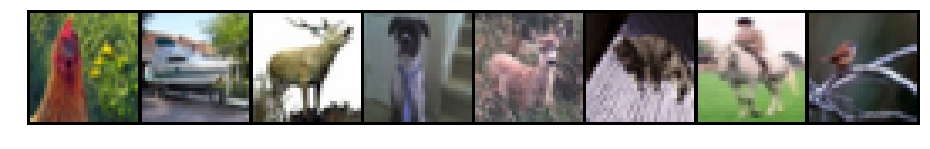

In [75]:
# transform images to tensor and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# create dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

cifar_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# plot sample of images
plot_images(trainloader, classes)

## Custom Dataset

Class cartoon has 9924 entries.
Class cyberpunk has 9859 entries.
Class noir has 3567 entries.
True labels:  cyberpunk     cyberpunk     cartoon     cartoon     cartoon     cartoon      noir     cartoon


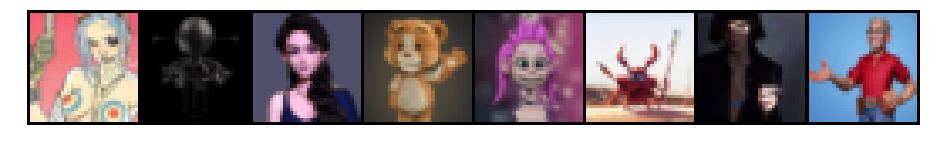

In [4]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

target_idx_dct = get_target_index(dataset)
for k,v in target_idx_dct.items():
    print(f"Class {k} has {v['length']} entries.")

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)

plot_images(dataloader, dataset.classes, image_number = 8)

## cDCGAN Model

In [74]:
def weights_init(m):
    '''
    Custom weights initialization called on netG and netD
    '''
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [97]:
class cDiscriminator(nn.Module):
    
    def __init__(self, n_classes, ngpu):
        
        super(cDiscriminator, self).__init__()
        
        self.ngpu = ngpu
        
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.convolution_layers = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            # nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ndf * 8),
            # nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
        )
        
        self.linear_layers = nn.Sequential(
            
            nn.Linear(in_features = 1 + n_classes, # flattened output from last conv + embedding
                      out_features = 512), # arbitrary + based on external references
            
            nn.LeakyReLU(0.2, inplace=True) ,
        
            nn.Linear(in_features = 512, # output from last linear layer
                      out_features = 1), # true or false image
            
            nn.Sigmoid()
        )
        

    def forward(self, input, labels):
        
        x = self.convolution_layers(input) # run input through convolutional layers
        # print(x.shape) # output shape: (128,1,1,1)
        x = x.view(x.size(0), -1) # flatten output from main
        # print(x.shape) # output shape: (128,1)
        y = self.label_embedding(labels) # create label layer
        # print(y.shape) # output shape: (128,3)
        x = torch.cat((x, y), -1) # concatenate flattened output to label layer
        # print(x.shape) # output shape: (128,4)
        x = self.linear_layers(x) # run flattened + merged layer through linear layers
        
        return x
    

In [98]:
# Generator Code

class cGenerator(nn.Module):
    
    def __init__(self, n_classes, ngpu):
        
        super(cGenerator, self).__init__()
        
        self.ngpu = ngpu
        
        self.n_classes = n_classes
        
        self.label_emb = nn.Embedding(n_classes, n_classes)
        
        self.main = nn.Sequential(
            
            # input is Z + n_classes, going into a convolution
            nn.ConvTranspose2d(nz + n_classes, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 16 x 16
            # nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input, labels):
    
        # Concatenate label embedding and noise to produce input
        flat_embed_input = torch.cat((self.label_emb(labels), input), -1)

        # reshape flattened layer to torch.Size([128, nz+n_classes, 1, 1])
        reshaped_input = flat_embed_input.view((-1,nz + self.n_classes,1,1)) 
        
        gen_img = self.main(reshaped_input)
        
        return gen_img
  

In [99]:
class cDCGAN(object):
    
    
    def _checkDirectory(self, dirName):
        
        if not os.path.exists(dirName):
            os.makedirs(dirName)
    
    
    def __init__(self, dataloader, classes, save_dir, num_epochs,
                 criterion, netD, netG, optimizerD, optimizerG,
                 device):
        
        # data parameters
        self.dataloader = dataloader
        self.classes = classes
        self.n_classes = len(classes)
        
        # save file locations
        self._checkDirectory(save_dir) # check whether save dir exists
        self.checkpoint_dir = os.path.join(save_dir, 'checkpoints')
        self._checkDirectory(self.checkpoint_dir) # create checkpoints dir
        self.fake_image_dir = os.path.join(save_dir, 'fake_images')
        self._checkDirectory(self.fake_image_dir) # create fake images dir
        
        # model parameters
        self.num_epochs = num_epochs # number of epochs to train for
        self.start_epoch = 1 # the starting epoch
        self.criterion = criterion # loss function
        self.real_label = 1 # Establish convention for real and fake labels during training
        self.fake_label = 0

        # networks init
        self.netD = netD
        self.netG = netG
        self.optimizerD = optimizerD
        self.optimizerG = optimizerG
        
        # device
        self.device = device # specify device being used
        
        # Create fixed noise to visualize the progression of the generator
        self.fixed_noise = torch.randn(64, nz, device=self.device) # torch.Size([64, 100])
            
        
    def generate_fake_images(self, class_index_tensor, noise, image_name = 'random', save = True):
        
        '''
        Generate a batch of fake images using current generator weights.
        
        Inputs
        
            class_index_tensor (LongTensor)
                The class index to create fake images for. The number of fake images generated is equal
                to the length of the tensor. So a tensor filled with 10 "1"s will generate 10 images for
                the class that corresponds to "1".
                
            noise (Tensor)
                Random noise that will be put through the generator weights to produce an image.
        
            image_name (STR)
                Image name for the saved file.
                If running this function in model training, image_name should contain a changing variable,
                otherwise the files will just keep overwriting each other with the same name.
                Default: 'random' (in case save = True but no image_name provided)
            
            save (BOOL)
                If save is TRUE, the image file will be saved in the specified "self.fake_image_dir".
                Otherwise, just return the image data for plotting.
                Default: TRUE
            
        ''' 
        with torch.no_grad():
            # create fake images for a the labels in class_index_tensor
            fake = self.netG(noise, class_index_tensor).detach().cpu()
        
        if save: # save images in the fake_image_dir
            save_image(fake.data, f'{self.fake_image_dir}/{image_name}.png',
                       nrow=8, padding=2, normalize=True)
        
        return fake.data
    

    def train(self):
        
        '''
        Training loop
        '''
        if self.num_epochs == 0:
            print(f"No epochs set for training. Exiting training loop.")
            return
            
        # Lists to keep track of progress
        self.G_losses = [] # generator loss
        self.D_losses = [] # discriminator loss
        iters = 0

        print("Starting Training Loop...")
        # For each epoch
        for epoch in range(self.start_epoch, self.start_epoch + self.num_epochs):
            # For each batch in the dataloader
            for i, (imgs, class_labels) in enumerate(self.dataloader):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################

                ## Train with all-real batch
                ###########################
                self.netD.zero_grad()

                # Format batch
                real_imgs = imgs.to(self.device)
                b_size = real_imgs.size(0)

                # Set ground truth labels as REAL
                validity_label = torch.full((b_size,), self.real_label, device=device)

                # Forward pass real batch through D
                output = self.netD(real_imgs, class_labels).view(-1)

                # Calculate loss on all-real batch
                errD_real = self.criterion(output, validity_label)

                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()


                ## Train with all-fake batch
                ###########################
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, device=device) # torch.Size([128, 10])

                # Generate batch of fake labels
                gen_labels = torch.randint(self.n_classes, (b_size,)).type(torch.LongTensor) # torch.Size([128, 3])

                # Generate fake image batch with G
                fake = self.netG(noise, gen_labels)

                # Update ground truth labels to FAKE
                validity_label.fill_(self.fake_label)

                # Classify all fake batch with D
                output = self.netD(fake.detach(), gen_labels).view(-1)

                # Calculate D's loss on the all-fake batch
                errD_fake = self.criterion(output, validity_label)

                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()

                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake

                # Update D
                self.optimizerD.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################

                self.netG.zero_grad()

                validity_label.fill_(self.real_label)  # fake labels are real for generator cost
                
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = self.netD(fake, gen_labels).view(-1)
                
                # Calculate G's loss based on this output
                errG = self.criterion(output, validity_label)
                
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                
                # Update G
                self.optimizerG.step()

                # Output training stats
                if i % 50 == 0:
                    print(f'[{epoch}/{self.start_epoch + self.num_epochs - 1}][{i}/{len(self.dataloader)}]\tLoss_D: {round(errD.item(),2)}\tLoss_G: {round(errG.item(),2)}\tD(x): {round(D_x,2)}\tD(G(z)): {round(D_G_z1/D_G_z2,2)}')

                # Save Losses for plotting later
                self.G_losses.append(errG.item())
                self.D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                # every 500 iterations, or on the last batch of the last epoch
                if (iters % 500 == 0) or ((epoch == self.num_epochs-1) and (i == len(self.dataloader)-1)):
                    
                    print("Saving a batch of fake images.")
                    
                    class_index = torch.arange(self.n_classes) # get class indices
                    for i in class_index:
                        class_index_tensor = torch.LongTensor(64).fill_(i) # repeat the same class index 10 times
                        self.generate_fake_images(class_index_tensor, self.fixed_noise,
                                                  image_name = f'{self.classes[i]}_e{epoch}', save = True)

                iters += 1

            # automatically save model if 5 epochs have passed
            if epoch > 1 and epoch % 5 == 0: self.save(epoch)

        print(f"Finished Training for {epoch} epochs.")
        self.save(epoch)
        
        
    def save(self, epoch):
        
        # save the model checkpoint
        filepath = f'{self.checkpoint_dir}/checkpoint_e{epoch}.pth.tar'
        print(f"=> Saving checkpoint: {filepath}")

        state = {
            'D_losses': self.D_losses,
            'G_losses': self.G_losses,
            'epoch': epoch,
            'netD_state_dict': self.netD.state_dict(),
            'optimizerD': self.optimizerD.state_dict(),
            'netG_state_dict': self.netG.state_dict(),
            'optimizerG': self.optimizerG.state_dict(),
        }

        torch.save(state, filepath) 

        
    def load(self, loadpath):
        '''
        When loading model checkpoint, just load the epoch and state dicts to continue training.
        The D-loss, G-loss, and fake images can be stored within their respective checkpoints,
        and referred to later when needed.
        '''
        if os.path.isfile(loadpath):
            print(f"=> loading checkpoint: {loadpath}")
            checkpoint = torch.load(loadpath)

            self.start_epoch = checkpoint['epoch'] + 1
            self.netD.load_state_dict(checkpoint['netD_state_dict'])
            self.netG.load_state_dict(checkpoint['netG_state_dict'])
            self.optimizerD.load_state_dict(checkpoint['optimizerD'])
            self.optimizerG.load_state_dict(checkpoint['optimizerG'])

            print(f"=> loaded checkpoint: {loadpath}")
            print(f"Last epoch was {checkpoint['epoch']}")

        else: 
            print(f"=> No checkpoint found at: {loadpath}")
        
        
    def visualize_results(self):
        
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(self.G_losses,label="G")
        plt.plot(self.D_losses,label="D")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        

## Implementation

The cDCGAN is trained for ... epochs on the CIFAR10 dataset and ... epochs on the novel dataset.

The model parameters were kept mostly similar for both training sets, with the only difference being the data parameters and the directory.

### Training Process

The training process was carried out as follows:

1) Initiailize cDCGAN object with designated parameters.

2) Train for a set number of epochs. The model automatically saves checkpoints at every 5 epochs, as well as after the last epoch.

3) If more training is desired, load model from last epoch to continue training.

### Results Analysis

A visualization of the images as the training progress is shown.

Using the model weights at the last checkpoint, different latent vectors were fed into the model to generate different sets of fake images.

### CIFAR10 Model

In [100]:
# Create the Discriminator
netD = cDiscriminator(len(cifar_classes), ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

# Create the generator
netG = cGenerator(len(cifar_classes), ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

cDiscriminator(
  (label_embedding): Embedding(10, 10)
  (convolution_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=11, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=512, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
cGenerator(
  (label_emb)

In [103]:
kwargs = {
    'dataloader': trainloader, # cifar dataloader
    'classes': cifar_classes, # cifar classes
    'save_dir':'cDCGAN-cifar',
    'num_epochs': 20,
    'criterion': nn.BCELoss(), # Initialize BCELoss function
    'netD': netD,
    'netG': netG,
    'optimizerD': optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)),
    'optimizerG': optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)),
    'device': device
}
    
cdcgan_cifar = cDCGAN(**kwargs)

In [ ]:
cdcgan_cifar.load('cDCGAN-cifar/checkpoints/checkpoint_e20.pth.tar')

In [104]:
cdcgan_cifar.train()

Starting Training Loop...
[1/20][0/391]	Loss_D: 1.28	Loss_G: 1.94	D(x): 0.67	D(G(z)): 2.33
Saving a batch of fake images.
[1/20][50/391]	Loss_D: 1.18	Loss_G: 1.14	D(x): 0.59	D(G(z)): 1.05
[1/20][100/391]	Loss_D: 1.19	Loss_G: 1.52	D(x): 0.61	D(G(z)): 1.53
[1/20][150/391]	Loss_D: 1.24	Loss_G: 1.27	D(x): 0.54	D(G(z)): 1.16
[1/20][200/391]	Loss_D: 1.18	Loss_G: 1.13	D(x): 0.56	D(G(z)): 1.03
[1/20][250/391]	Loss_D: 1.29	Loss_G: 1.37	D(x): 0.63	D(G(z)): 1.67
[1/20][300/391]	Loss_D: 1.07	Loss_G: 1.49	D(x): 0.59	D(G(z)): 1.22
[1/20][350/391]	Loss_D: 1.19	Loss_G: 1.2	D(x): 0.53	D(G(z)): 0.92
[2/20][0/391]	Loss_D: 1.34	Loss_G: 0.98	D(x): 0.51	D(G(z)): 0.96
[2/20][50/391]	Loss_D: 1.16	Loss_G: 1.12	D(x): 0.61	D(G(z)): 1.11
[2/20][100/391]	Loss_D: 1.14	Loss_G: 1.36	D(x): 0.62	D(G(z)): 1.33
Saving a batch of fake images.
[2/20][150/391]	Loss_D: 1.17	Loss_G: 1.05	D(x): 0.56	D(G(z)): 0.94
[2/20][200/391]	Loss_D: 1.26	Loss_G: 1.39	D(x): 0.63	D(G(z)): 1.57
[2/20][250/391]	Loss_D: 1.3	Loss_G: 1.01	D(x): 0

[15/20][150/391]	Loss_D: 1.14	Loss_G: 1.55	D(x): 0.62	D(G(z)): 1.29
[15/20][200/391]	Loss_D: 1.13	Loss_G: 1.98	D(x): 0.71	D(G(z)): 2.32
[15/20][250/391]	Loss_D: 0.99	Loss_G: 1.98	D(x): 0.79	D(G(z)): 2.28
[15/20][300/391]	Loss_D: 1.0	Loss_G: 1.24	D(x): 0.61	D(G(z)): 0.86
[15/20][350/391]	Loss_D: 1.03	Loss_G: 1.78	D(x): 0.67	D(G(z)): 1.44
=> Saving checkpoint: cDCGAN-cifar/checkpoints/checkpoint_e15.pth.tar
[16/20][0/391]	Loss_D: 0.92	Loss_G: 1.59	D(x): 0.67	D(G(z)): 1.12
[16/20][50/391]	Loss_D: 0.89	Loss_G: 1.87	D(x): 0.66	D(G(z)): 1.33
[16/20][100/391]	Loss_D: 1.04	Loss_G: 1.89	D(x): 0.66	D(G(z)): 1.65
Saving a batch of fake images.
[16/20][150/391]	Loss_D: 0.91	Loss_G: 1.48	D(x): 0.62	D(G(z)): 0.83
[16/20][200/391]	Loss_D: 1.04	Loss_G: 1.54	D(x): 0.65	D(G(z)): 1.39
[16/20][250/391]	Loss_D: 0.96	Loss_G: 1.39	D(x): 0.69	D(G(z)): 1.16
[16/20][300/391]	Loss_D: 1.85	Loss_G: 0.97	D(x): 0.28	D(G(z)): 0.34
[16/20][350/391]	Loss_D: 1.03	Loss_G: 1.33	D(x): 0.62	D(G(z)): 0.99
[17/20][0/391]	Loss

### Novel Dataset Model

In [89]:
# Create the Discriminator
netD = cDiscriminator(len(dataset.classes), ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

# Create the generator
netG = cGenerator(len(dataset.classes), ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

cDiscriminator(
  (label_embedding): Embedding(3, 3)
  (convolution_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=512, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
cGenerator(
  (label_emb): E

In [90]:
kwargs = {
    'dataloader': dataloader, # novel data dataloader
    'classes': dataset.classes, # novel dataset classes
    'save_dir':'cDCGAN',
    'num_epochs': 20,
    'criterion': nn.BCELoss(), # Initialize BCELoss function
    'netD': netD,
    'netG': netG,
    'optimizerD': optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)),
    'optimizerG': optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)),
    'device': device
}
    
cdcgan = cDCGAN(**kwargs)

In [62]:
cdcgan.load('cDCGAN/checkpoints/checkpoint_e60.pth.tar')

=> loading checkpoint: cDCGAN/checkpoints/checkpoint_e60.pth.tar
=> loaded checkpoint: cDCGAN/checkpoints/checkpoint_e60.pth.tar
Last epoch was 60


['cartoon', 'cyberpunk', 'noir']


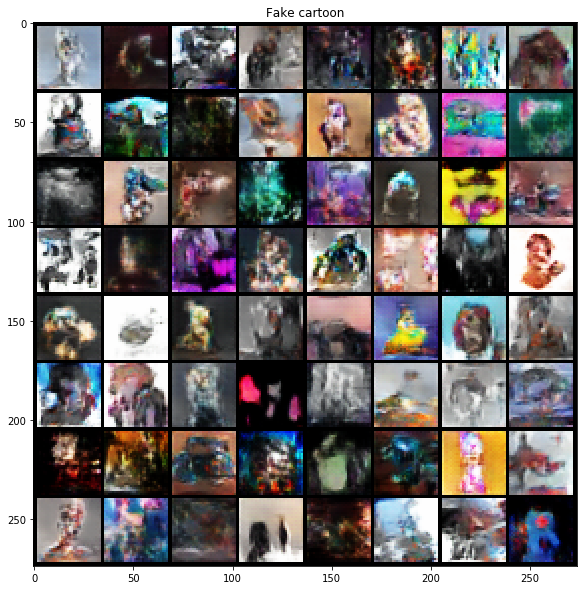

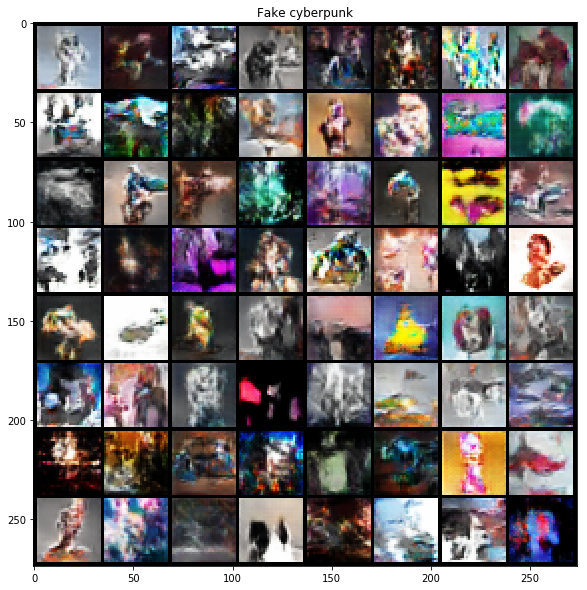

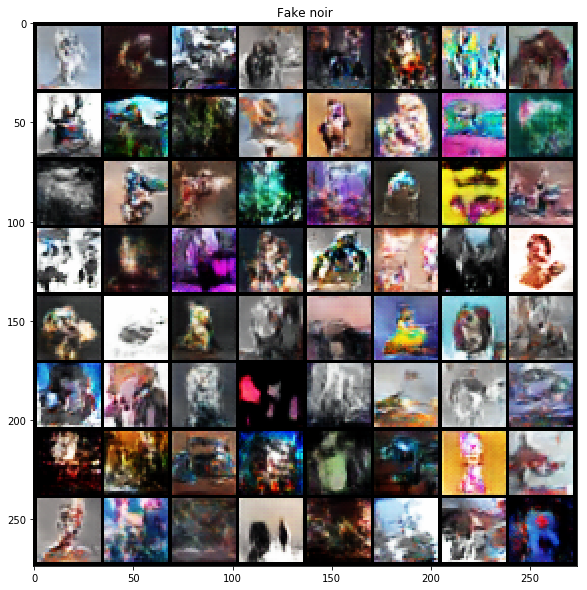

In [79]:
noise = torch.randn(64, nz, device=device)

for c in range(len(dataset.classes)):
    images = cdcgan.generate_fake_images(torch.LongTensor(64).fill_(c),
                                         noise = noise,
                                         save = False)
    plt.figure(figsize=(10,10))
    plt.title(f'Fake {dataset.classes[c]}')
    plt.imshow(np.transpose(vutils.make_grid(images, normalize = True), (1,2,0)))


## References

Brownlee, J. (2019, July 12). How to Develop a Conditional GAN (cGAN) From Scratch. Retrieved November 25, 2019, from https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/.

Desai, U. (2018, June 8). Training a Conditional DC-GAN on CIFAR-10. Retrieved November 25, 2019, from https://medium.com/@utk.is.here/training-a-conditional-dc-gan-on-cifar-10-fce88395d610.

Inkawhich, N. (2017). DCGAN Tutorial. Retrieved November 25, 2019, from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html.

Kang, H. (2017, August 22). znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN. Retrieved November 25, 2019, from https://github.com/znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN.

Karpathy, A., & Johnson, J. (2017). CS231n: Convolutional Neural Networks for Visual Recognition-Transfer Learning. Retrieved November 13, 2019, from https://cs231n.github.io/transfer-learning/#tf.

Linder-Noren, E. (2019). Conditional GAN Code. Retrieved from https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py

Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784. Retrieved from https://arxiv.org/pdf/1411.1784.pdf